# 7.3 Binomial distribution Naive Bayes Classifier

In the previous notebook we appied a Maximum Log-Likelihood estimation ($d_k(x) = ln\ p(\mathbf{x}/C_k)$) on features that follow a normal distribution. In this notebook we will use as well a Maximum Log-Likelihood estimation but **now the variables follow a binomial distribuion** (variables are either $1$ or $0$). 

As we are using a **naive** Bayes classifier, variables are again assumed **independent**:

$$P(x_i \cap x_j) = P(x_i)p(x_j) \; \forall i,j$$

In this notebook we will learn how a naive Bayes classifier can be trained (section 7.3.1) and tested (section 7.3.2) using binomial variables.

## Problem contex - Digit recognition

> Digit recognition system is the working of a machine to **train itself or recognizing the digits** from different sources like emails, bank cheque, papers, images, etc. and in different real-world scenarios for online handwriting recognition on computer tablets or system, recognize **number plates of vehicles**, processing bank cheque amounts, numeric entries in forms filled up by hand (say — tax forms) and so on.

For completing our plate detector and recognition system, we are going to learn how to construct a digit recognition system (can be generalized for all plate possible characters) usign a naive Bayes classifier.

<img src="./images/plateRecognition.png" width="400"/>

For this problem we need a set of digit images that will be used as training dataset for our classifier. For car plate recognition we would have to classify digits and letter. For simplify this, we are going to use only digit images (only 10 possible classes). You can find provided images in `./images/train_binary/imagen{0-9}_{1-500}.png`, having 500 images for each digit.

*Note that images contains handwritten digits instead of plate ones, but it's the same procedure.*

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

images_path = './images/'

### 7.3.1 Training a naive Bayes classifier (binomial distribution)

We will follow the same procedure than in the previous notebook, but adapted to binomial distribution. First, we need to remember how the discriminant function of a Bayesian classifier is created:$\\[10pt]$

$$
\begin{eqnarray}
&d_k(x) &= P(C_k/\mathbf{x}) = \frac{p(\mathbf{x}/C_k)P(C_k)}{P(\mathbf{x})}\\
\xrightarrow{P(\mathbf{x})\text{ is a constant value }\forall k} \hspace{0.2cm}&d_k(x) &= p(\mathbf{x}/C_k)P(C_k)\\[7pt]
\xrightarrow{\text{ ln doesn't alter maximum }} \hspace{0.2cm} &d_k(x) &= lnp(\mathbf{x}/C_k) + lnP(C_k)\\[7pt]
\xrightarrow{\text{If } P(C_k) = P(C_j)\; \forall \ j,k }\hspace{0.2cm} &d_k(x) &= lnp(\mathbf{x}/C_k)
\end{eqnarray}
\\[8pt]$$

For this problem, we have $28x28$ pixels images, and each pixel is a feature that can be either $0$ or $1$:

$$\mathbf{x} = [x_1 \; x_2 \; \ldots \; x_f \; \ldots \; x_{28x28}]$$

And the probability of a pixel $x_f$ belongs to a class $C_i$ is:

$$p(x_f/C_i) = (p_f^i)^{x_f} *  (1 - p_f^i)^{(1 - x_f)}$$

Being $p_f^i$ the probability that $x_f = 1$ if $\mathbf{x} \in C_i$.  

Our features are independent (naive Bayes classifier), so we can multiply all probaiblities:$\\[5pt]$

$$p(\mathbf{x}/C_i) = \Pi_{f=1}^n p(x_f/C_i) = \Pi_{f=1}^n (p_f^i)^{x_f}*(1 - p_f^i)^{(1 - x_f)}$$

Finally, for obtaining the discriminant function, we apply the logaritm:$\\[7pt]$

$$ln\ p(\mathbf{x}/C_i) = \Sigma_{f=1}^n [x_f \cdot ln(p_f^i) + (1- x_f) \cdot ln\ (1-p_f^i)] = \Sigma_{f=1}^n x_f \cdot ln\ \frac{p_f^i}{1-p_f^i} + \Sigma_{f=1}^n ln\ (1-p_f^i)$$

$$d_i(x) = ln \ p(\mathbf{x}/C_i) + ln \ P(C_i) = \underbrace{ln \ P(C_i) + \Sigma_{f=1}^n ln\ (1-p_f^i)}_{w_{n+1}^i} + \Sigma_{f=1}^n x_f \cdot \underbrace{ln\ \frac{p_f^i}{1-p_f^i}}_{w_f^i}$$

As we can see, the function is lineal.

### **<span style="color:green"><b><i>ASSIGNMENT 1a</i></b></span>**

**Setting up the data**

The first step for training the classifier is preparing the images, this is done vectorizing each image. **Our task** is to construct a matrix containing all the images data (`./images/train_binary/imagen{0-9}_{1-500}.png`), this array will have 3 dimensions $(n\_pixels, n\_images, n\_classes)$. Each column of the array contains a vectorized version of the corresponding image (the are `m_images` columns for `n_images` images). In the third column we have the classes (we have 10 possible classes {0-9}).

<img src="./images/vectorize.png" width="700"/>

Read all images (500 images for each digit) and obtain the mentioned matrix storing all data. Images are grayscale, you will have to segment them first using openCV in order to follow a binomial distribution.

In [3]:
## Training

# Initialize matrix
r,c = 28,28
dataset = np.zeros((r*c,500,10))

# For each class
for number in range(10):
    # For each image in the class
    for i in range(1,501):
        # Read the image
        path = images_path + "train_binary/imagen" + str(number) + "_" + str(i) + ".png"
        image = cv2.imread(path,0)
        # Binarize it
        _,binarized = cv2.threshold(image,100,1,cv2.THRESH_BINARY)
        vector_binarized = binarized.reshape((-1,1))
        # Reshape it
        dataset[:,i-1,number] = vector_binarized[:,0]

### **<span style="color:green"><b><i>ASSIGNMENT 1b</i></b></span>**

**Computing probabilities**

Now, we will compute the probabilities matrix that allows us to compute the weights:

$$d_i(x) = ln \ p(\mathbf{x}/C_i) + ln \ P(C_i) = \underbrace{ln \ P(C_i) + \Sigma_{f=1}^n ln\ (1-p_f^i)}_{w_{n+1}^i} + \Sigma_{f=1}^n x_f \cdot \underbrace{ln\ \frac{p_f^i}{1-p_f^i}}_{w_f^i}$$

In this case, the weights are constructed from probabilities ($p_f^i$). Each variable $p_f^i$ contains the probability that $x_f = 1$ if $\mathbf{x} \in C_i$. For binomial distribution, computing the probabilities is straightforward. We just have to count the number of times that each pixel is `1` in each class, and divide it by the number of imaged used:

$$p_{f}^i = \frac{1}{N}\Sigma_{k=1}^{N}x_{f,k}^{i}$$$\\[3pt]$

*Regarding to our problem, $N=500$ as we have $500$ images for each class and the range of $f$ is $[0-783]$*.

<img src="./images/probabilities.png" width="700"/>$\\[2pt]$

**What to do?** Construct a 2D matrix **containing all the probabilities** ($matrix[f,i] = p_f^i$). Then, **unvectorize the probabilities** in the matrix (2D $\rightarrow$ 3D), constructing **heatmaps**, which are images where each pixel contains its own probability. Finally, **plot the heatmaps** in order to **check** if we are in a good way:  

<img src="./images/heatmaps.png" width="700"/>

*Tip: try to use [np.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) for computing the probaiblities in order to avoid loops, which are usually slower (check the `axis` argument).*

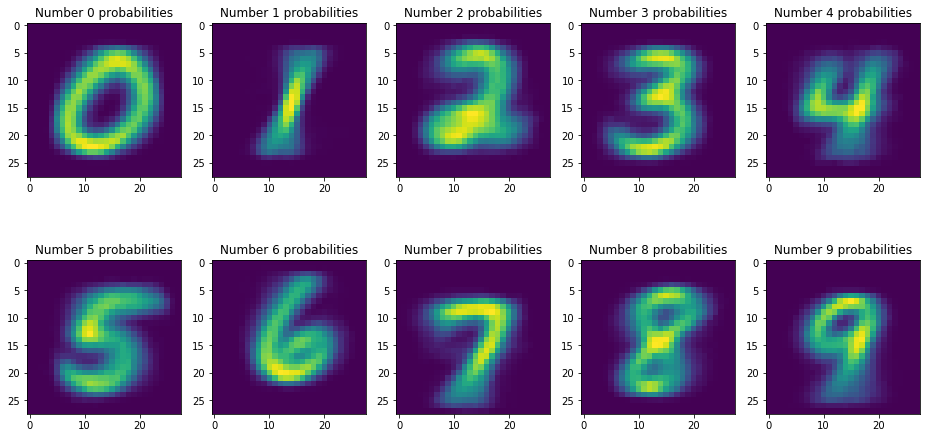

In [5]:
# Compute probabilities
probabilities = np.sum(dataset, axis=1)/500

# Reshape to obtain heatmaps
heatmaps = probabilities.reshape(r,c,10)

# Plot heatmaps
for i in range(2):
    for j in range(5):
        plt.subplot(2,5, i*5+(j+1))
        plt.title("Number " + str(i*5+j) + " probabilities")
        plt.imshow(heatmaps[:,:,i*5+j])

### **<span style="color:green"><b><i>ASSIGNMENT 1c</i></b></span>**

**Computing weights**

As you know, once we obtain the weights of the discriminant function, we can compute the discriminant functions and then classify new images. So, this is the last training step.

$$
\begin{eqnarray}
w_f^i &=& ln\ \frac{p_f^i}{1-p_f^i}\\[5pt]
w_{n+1}^i &=& ln\ P(C_k) + \Sigma_{f=1}^n ln(1- p_f^i)
\end{eqnarray}
$$

Note that we can't neither divide by 0 nor compute the logarithm of 0. If we want to compute the weights, we should **previously replace 0 and 1 probabilities for close numbers** (e.g. 0.0001 and 0.9999), this can be done using [np.where](https://numpy.org/doc/1.18/reference/generated/numpy.where.html).  

Again, as we don't have any prior information about the occurences of each class, the prior probability $P(C_k)$ should be $1/n\_classes$ for each class $k$.

**What to do?** Construct a 2D matrix containing the weights of the classifier.

*For applying the natural logarithm to all the elements of a matrix, you can use [np.log](https://numpy.org/doc/1.18/reference/generated/numpy.log.html?highlight=log#numpy.log).*

In [7]:
## Weight calculation

# Replace 0 and 1 values
probabilities = np.where(probabilities==0, 0.001, probabilities)
probabilities = np.where(probabilities==1, 0.999, probabilities)

# Initialize matrix
weights = np.zeros((r*c+1,10))

# Compute weights
weights[:-1,:] = np.log(probabilities/(1-probabilities))
weights[-1,:] = np.log(0.1) + np.sum(np.log(1-probabilities),axis=0)

### 7.3.2 Testing a naive Bayes classifier (binomial distribution)

Once we have the weights $w_{n+1}^i$ and $w_f^i$, we can evaluate the discriminant functions $d_i(x) \; (i=0,1,\ldots,9)$ for each vector $\mathbf{x}$ (a new vectorized image that have not been used in training phase).

$$d_i(\mathbf{x}) = w_{n+1}^i + \Sigma_{f=0}^{783}w_f^i \cdot x_f \quad i = 0,\ldots, 9$$

We will have 10 outputs, the results of the discriminant functions (one per class). As we are estimating the **maximum log-likelihood**, the assigned class will be maximum distriminant function.

### **<span style="color:green"><b><i>ASSIGNMENT 2</i></b></span>**

For this exercise, we provide the numPy matrix `digitos.npy` located at `./test_binary/`. It is a 1D matrix containing 50 digits between 0 and 9 that are the classes of the images `./test_binary/timage{1-50}`. **Your task** is to classify those 50 images and check if the output of your classifier match with the actual class (contained in `digitos.npy`). In this way, we can estimate how good is our classifier.

*If you trained your classifier with the provided images, you should have 41/50 hits, or a 82% of accuracy.*

In [10]:
## Testing

# Load provided matrix
results = np.load(images_path + "test_binary/digitos.npy")
hits = 0

# Classify each testing image
for i in range(1,51):
    f_pesos = np.zeros((10))
    # Read the image
    path = images_path + "test_binary/timage" + str(i) + ".png"
    image = cv2.imread(path,0)
    # Binarize it
    _,binarized = cv2.threshold(image,100,1,cv2.THRESH_BINARY)
    # Vectorize it
    vector_binarized = binarized.reshape((-1,1))
    vector_binarized = np.append(vector_binarized,[1])
    # Evaluate the discriminant functions
    for j in range(10):
        f_pesos[j] = np.sum(weights[:,j] * vector_binarized)
    # Get the maximum
    res = np.where(f_pesos == np.amax(f_pesos))
    if res == results[i-1]:
        hits = hits + 1
        
# Print the accuracy
print(hits)

41


### **<span style="color:green"><b><i>EXTRA: ASSIGNMENT 3</i></b></span>**

You can also test your classifier with your own images, try to write a digit in a paper and make a photo with your phone. You will need some preprocessing first in order to preparing the image as a feature vector $\mathbf{x}$.$\\[5pt]$

<img src="./images/testcamera.jpeg" width="300"/>$\\[5pt]$

First, you will need to segment the region of interest (crop the digit). Then, you will have to resize the image to a $28\times28$ image (classifier input), you can use [cv2.resize](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d) for that. Finally, binarize and vectorize the image so it can be used as input for the classifier. Follow the steps done in *assignment 2* for classify the image and show the results!

<img src="./images/extra_example.png" width="700"/>

Text(0.5, 1.0, 'Image classified as [5]')

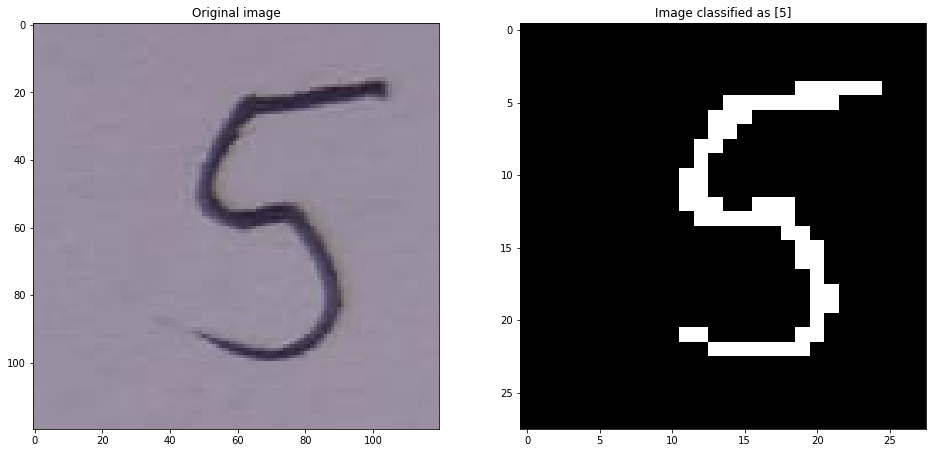

In [18]:
## Testing with our own image

# Read image and convert it to grayscale
color_image = cv2.imread(images_path + 'testcamera.jpeg', -1)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

# Crop ROI
color_image = color_image[380:500,1390:1510,:]
image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

# Binarize it
image = cv2.resize(image,(r,c))
_,binarized = cv2.threshold(image,130,1,cv2.THRESH_BINARY_INV)

# Reshape the image
vector_binarized = binarized.reshape((-1,1))
vector_binarized = np.append(vector_binarized,[1])

# Evaluate the discriminant functions
for j in range(10):
    f_pesos[j] = np.sum(weights[:,j] * vector_binarized)
    
# Get the maximum
res = np.where(f_pesos == np.amax(f_pesos))

# Plot the results
plt.subplot(121)
plt.imshow(color_image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(binarized,cmap="gray")
plt.title("Image classified as " + str(res[0]))

## Conclusion

Excellent! You learned how to:

- construct and train an efficient naive Bayes classifier for binary images
- test and obtain the accuracy of the classifier
- classify images, in the context of handwritten digits or car plates characters (just changing the training dataset).